In [1]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing



In [2]:
#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

In [4]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

workers = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {workers}")
# Set the number of workers for DataLoader

# Common transform: resize to 224x224, convert to tensor, normalize
common_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
common_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=common_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=common_test_transform
)

# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=True,
    transform=common_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=True,
    transform=common_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=True,
    transform=common_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
batch_size = 712
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Number of CPU cores available: 144
CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.


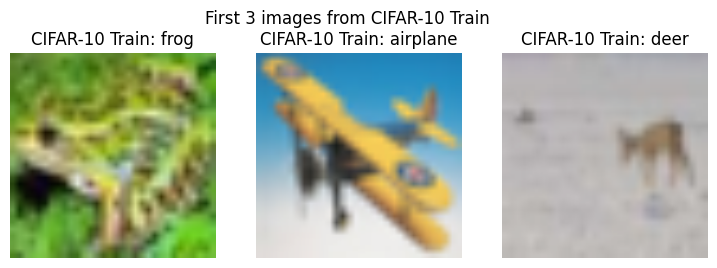

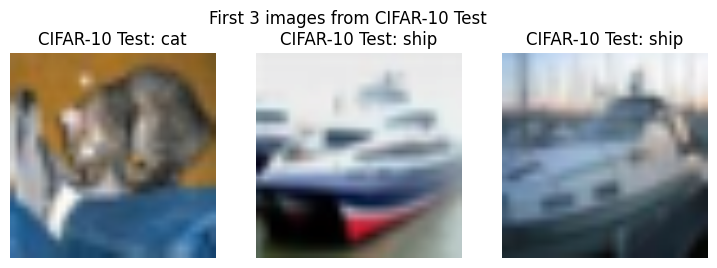

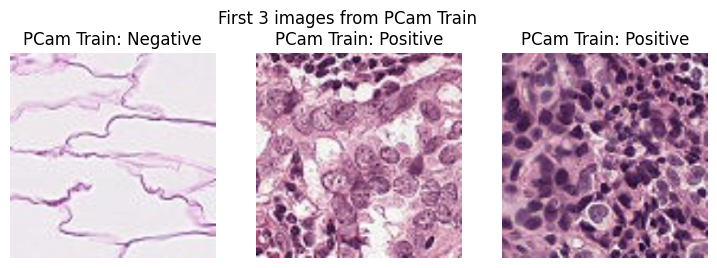

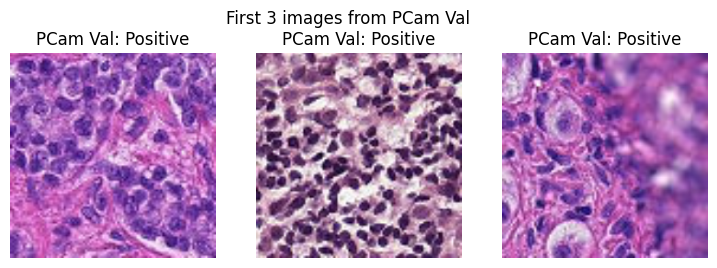

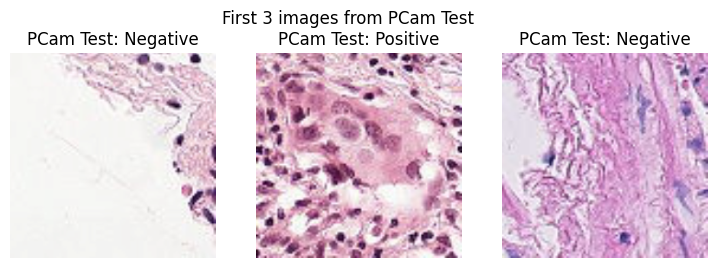

In [4]:
# Helper function to denormalize and show an image
def imshow(img, mean=IMAGENET_MEAN, std=IMAGENET_STD, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Function to show first 3 images from a DataLoader
def show_first_n_images(dataloader, class_names, dataset_name, n=3):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize=(n * 3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        if class_names is not None:
            plt.title(f"{dataset_name}: {class_names[labels[i]]}")
        else:
            plt.title(f"{dataset_name}: Label {labels[i].item()}")
    plt.suptitle(f"First {n} images from {dataset_name}")
    plt.show()

# Class names for CIFAR-10 and PCam
cifar10_classes = cifar10_train.classes
pcam_classes = ['Negative', 'Positive']

# Show images from each DataLoader
show_first_n_images(cifar10_train_loader, cifar10_classes, "CIFAR-10 Train")
show_first_n_images(cifar10_test_loader, cifar10_classes, "CIFAR-10 Test")
show_first_n_images(pcam_train_loader, pcam_classes, "PCam Train")
show_first_n_images(pcam_val_loader, pcam_classes, "PCam Val")
show_first_n_images(pcam_test_loader, pcam_classes, "PCam Test")


In [5]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models for CIFAR-10 and PCam
cifar_model = initialize_resnet34(num_classes=10, device=device)
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 10 classes on cuda (DataParallel=True)
Initialized ResNet34 for 2 classes on cuda (DataParallel=True)


In [11]:
torch.save(cifar_model.state_dict(), 'cifar_model.pth')
torch.save(pcam_model.state_dict(), 'pcam_model.pth')


In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL

# Helper: PyTorch model wrapper for scikit-activeml
class TorchWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def fit(self, train_loader, epochs=5):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
    def predict_proba(self, data_loader):
        self.model.eval()
        all_probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
        return np.concatenate(all_probs, axis=0)

# Active learning parameters
INIT_SIZE = 50
QUERY_SIZE = 5
N_CYCLES = 10

# Example for CIFAR-10
dataset = cifar10_train
model = cifar_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapper = TorchWrapper(model, device)

# 1. Split indices
all_indices = np.arange(len(dataset))
np.random.seed(42)
labeled_indices = np.random.choice(all_indices, size=INIT_SIZE, replace=False)
unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)

# 2. Prepare label array for scikit-activeml
y = np.full(len(dataset), MISSING_LABEL)
y[labeled_indices] = [dataset[i][1] for i in labeled_indices]

# 3. Active learning loop
for cycle in range(N_CYCLES):
    print(f"\nAL Cycle {cycle+1}/{N_CYCLES} | Labeled: {len(labeled_indices)} | Unlabeled: {len(unlabeled_indices)}")

    # --- Training ---
    train_subset = Subset(dataset, labeled_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    wrapper.fit(train_loader, epochs=5)

    # --- Uncertainty Sampling ---
    unlabeled_subset = Subset(dataset, unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    probs = wrapper.predict_proba(unlabeled_loader)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    query_indices = np.argsort(-entropy)[:QUERY_SIZE]
    newly_selected = unlabeled_indices[query_indices]

    # --- Update pools ---
    labeled_indices = np.concatenate([labeled_indices, newly_selected])
    unlabeled_indices = np.setdiff1d(unlabeled_indices, newly_selected)
    y[newly_selected] = [dataset[i][1] for i in newly_selected]

    # (Optional) Track selected samples, compute XAI, evaluate, etc.

    if len(unlabeled_indices) == 0:
        print("Unlabeled pool exhausted.")
        break

print("Active learning completed.")



AL Cycle 1/10 | Labeled: 50 | Unlabeled: 49950

AL Cycle 2/10 | Labeled: 55 | Unlabeled: 49945

AL Cycle 3/10 | Labeled: 60 | Unlabeled: 49940

AL Cycle 4/10 | Labeled: 65 | Unlabeled: 49935

AL Cycle 5/10 | Labeled: 70 | Unlabeled: 49930

AL Cycle 6/10 | Labeled: 75 | Unlabeled: 49925

AL Cycle 7/10 | Labeled: 80 | Unlabeled: 49920

AL Cycle 8/10 | Labeled: 85 | Unlabeled: 49915

AL Cycle 9/10 | Labeled: 90 | Unlabeled: 49910

AL Cycle 10/10 | Labeled: 95 | Unlabeled: 49905
Active learning completed.


In [7]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:
# For CIFAR-10
cifar_class_names = cifar10_train.classes
cifar_results = evaluate_model(cifar_model, cifar10_test_loader, device, class_names=cifar_class_names)

# For PCam
#pcam_class_names = ['Negative', 'Positive']
#pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)


Accuracy: 0.4144
Accuracy for airplane: 0.8790 (1000 samples)
Accuracy for automobile: 0.1580 (1000 samples)
Accuracy for bird: 0.1830 (1000 samples)
Accuracy for cat: 0.2380 (1000 samples)
Accuracy for deer: 0.8930 (1000 samples)
Accuracy for dog: 0.7280 (1000 samples)
Accuracy for frog: 0.6700 (1000 samples)
Accuracy for horse: 0.1020 (1000 samples)
Accuracy for ship: 0.1210 (1000 samples)
Accuracy for truck: 0.1720 (1000 samples)

Confusion Matrix:
[[879   1   0   1  82   6  16   1  13   1]
 [724 158   0   2  56   6  26  12   5  11]
 [142   4 183  12 371 109 163   7   9   0]
 [110   9  11 238 278 173 157  14   7   3]
 [ 32   0   2   1 893  27  39   4   2   0]
 [ 29   3  13  65 139 728  15   7   1   0]
 [ 26   0   4   8 233  58 670   1   0   0]
 [ 75   2   7  12 711  74  16 102   1   0]
 [749   3   0   0 102   7  17   1 121   0]
 [526  45   0   2 172   7   8  42  26 172]]

Classification Report:
              precision    recall  f1-score   support

    airplane       0.27      0.88 

In [15]:
import shap
import torch
import numpy as np
# Assuming cifar_model and device are already defined and the model is trained
# Assuming cifar10_test_loader is already defined

# Ensure the model is on the correct device
cifar_model.to(device)

# Unwrap DataParallel for SHAP if necessary
if isinstance(cifar_model, torch.nn.DataParallel):
    model_for_shap = cifar_model.module
else:
    model_for_shap = cifar_model

# --- Set the model to evaluation mode ---
# This is important for consistent behavior with explainability methods like SHAP
model_for_shap.eval()

# Patch in-place ReLU (still necessary as a common fix)
def replace_relu_with_out_of_place(model):
    for child_name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU):
            # Replace in-place ReLU with out-of-place ReLU
            setattr(model, child_name, torch.nn.ReLU(inplace=False))
        else:
            # Recursively apply to child modules
            replace_relu_with_out_of_place(child)

print("Attempting to replace in-place ReLUs...")
replace_relu_with_out_of_place(model_for_shap)
print("In-place ReLU replacement attempted.")


# --- Potential issue location based on traceback ---
# The error often occurs in residual connections (like in ResNet BasicBlock)
# at the point of addition (e.g., `out += identity`).
# While `+=` is usually out-of-place with autograd, sometimes with views
# created by preceding operations, it can cause this error.
# A conceptual fix is to ensure this operation is explicitly out-of-place:
# Instead of `out += identity`, use `out = out + identity`.
# Fixing this requires modifying the forward pass of the specific block
# in your model (e.g., the BasicBlock in ResNet). This cannot be done
# generically here without redefining the model architecture or block.
# If you are using a standard torchvision ResNet, you might need to
# explore if there's a version or a way to build it that avoids this,
# or potentially define a custom BasicBlock.
# -----------------------------------------------------


# Get a batch of images from the test loader
try:
    images, labels = next(iter(cifar10_test_loader))
    # Move images to the same device as the model
    images = images[:5].to(device) # Using a small number of images for explanation
except StopIteration:
    print("Error: cifar10_test_loader is empty.")
    # Handle the case where the loader is empty, maybe load the dataset directly
    # or ensure the loader is properly initialized.
    # Exit or raise an error if no data is available.
    exit() # Or handle appropriately


# Use a small background set (also on the correct device)
# SHAP recommends using a representative sample of the training data for the background
# but using a subset of the input images themselves can sometimes work for debugging
background = images[:min(3, images.shape[0])].to(device) # Ensure background has at least 3 images if possible

# DeepExplainer
# Pass the model and the background data
explainer = shap.GradientExplainer(model_for_shap, background)

print(f"Calculating SHAP values for {images.shape[0]} images...")
# Calculate SHAP values for the input images
# The error happens here during the internal gradient calculation by SHAP
shap_values = explainer.shap_values(images)
print("SHAP value calculation completed.")

# Visualize
# Move images back to CPU for visualization if they were on GPU
shap.image_plot(shap_values, images.cpu().numpy())

Attempting to replace in-place ReLUs...
In-place ReLU replacement attempted.


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def explain_with_gradcam(model, dataloader, device, target_layer='layer4', num_samples=5, class_names=None):
    """
    Computes and visualizes GradCAM for a batch of images.
    """
    device = torch.device("cuda:0")
    model = model.to(device)
\
    model.eval()
    gradcam_model = model.module if isinstance(model, torch.nn.DataParallel) else model
    cam_extractor = GradCAM(gradcam_model, target_layer=target_layer)
    images, labels = next(iter(dataloader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples].cpu().numpy()
    
    for idx in range(num_samples):
        input_img = images[idx].unsqueeze(0)
        input_img = input_img.to(device)
        out = model(input_img)
        pred_class = out.argmax(dim=1).item()
        # Get the CAM for the predicted class
        activation_map = cam_extractor(pred_class, out)
        # Visualize
        img = input_img.cpu().squeeze()
        img = img * torch.tensor(IMAGENET_STD).view(3,1,1) + torch.tensor(IMAGENET_MEAN).view(3,1,1)
        img = img.clamp(0, 1)
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.title(f"Original (Label: {labels[idx]})")
        plt.imshow(to_pil_image(img))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title(f"GradCAM (Pred: {pred_class})")
        plt.imshow(to_pil_image(img))
        plt.imshow(activation_map[0].cpu().numpy(), alpha=0.5, cmap='jet')
        plt.axis('off')
        plt.show()
    cam_extractor.clear_hooks()

# Example usage (for CIFAR-10 test set):
explain_with_gradcam(cifar_model, cifar10_test_loader, device, target_layer='layer4', num_samples=5, class_names=cifar_class_names)


ValueError: Unable to find all submodules ['layer4'] in the model

In [25]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda:0")
model = model.to(device)


# Unwrap model if needed
gradcam_model = model.module if isinstance(model, torch.nn.DataParallel) else model
target_layers = [gradcam_model.layer4[-1]]

cam = GradCAM(model=gradcam_model, target_layers=target_layers)

# Prepare input tensor (should be shape [B, 3, H, W], normalized)
input_tensor = images[:5]  # Already normalized and on device
input_tensor = input_tensor.to(device)
# Create targets (e.g., predicted class for each image)
outputs = gradcam_model(input_tensor)
preds = outputs.argmax(dim=1).cpu().numpy()
targets = [ClassifierOutputTarget(int(p)) for p in preds]

grayscale_cams = cam(input_tensor=input_tensor, targets=targets)

# Visualization
for idx in range(num_samples):
    # Convert tensor to numpy image in [0, 1] range for overlay
    img = images[idx].cpu().numpy().transpose(1, 2, 0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    visualization = show_cam_on_image(img, grayscale_cams[idx], use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"GradCAM for sample {idx} (Pred: {preds[idx]})")
    plt.show()


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.